## Загрузка и первичный осмотр данных

**Цели:** Собрать датасет с заказами по папкам, ознакомиться со структурой данных и проверить их качество

In [1]:
# Импорт библиотек

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

/Users/ekaterinatihonova/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:

# Загрузка данных

# задаем переменную way, содержащую путь к папке data
way = os.getcwd() + '/data'

# создаем 3 пустыч списока, куда будут добавляться пути к файлам 3 разных df
file_paths_orders = []
file_paths_order_status = []
file_paths_products = []

# запускаем цикл for совместно с методом os.walk(way) по папке data
# path - текущий путь к папке 
# dirs - список подпапок в текущей папке
# files - список файлов в папке
for path, dirs, files in os.walk(way):
    # Вложенный цикл для перебора файлов в текущей папке
    for file in files:
        # Проверка формата файла — файл должен заканчиваться на '.csv'
        if file.endswith('.csv'):
            if file.startswith('products'):
                # Построение полного пути к файлу с помощью os.path.join(), 
                file_path_products = os.path.join(path, file)
                # Добавляем получившийся путь в список
                file_paths_products.append(file_path_products)
            elif file.startswith('order_'):
                file_path_order_status = os.path.join(path, file)
                file_paths_order_status.append(file_path_order_status)
            else:
                file_path_orders = os.path.join(path, file)
                file_paths_orders.append(file_path_orders)


1. `df_orders` — датафрейм на основе датасетов `orders.csv` с добавлением колонки `manager` с именами менеджеров и колонки `date` с датами. Итоговый датафрейм отсортирован по возрастанию `order_id` и `product_id`.

In [3]:
# создаем пустой датафрейм df_orders
df_orders = pd.DataFrame()

# запускаем цикл по каждому пути к файлу в списке путей file_paths_orders
for path in file_paths_orders:
    # считываем каждый файл
    data = pd.read_csv(path)
    data['manager'] = path.split('/')[-2]
    data['date'] = path.split('/')[-3]
    df_orders = pd.concat([df_orders, data], axis=0, ignore_index=True)
    
df_orders = df_orders.sort_values(by=['order_id', 'product_id'])

In [4]:
df_orders.shape

(4603, 5)

2. `df_order_status` — на основе датасетов `order_status.csv`. Отсортируйте датафрейм по возрастанию `order_id`. 

In [5]:
# создаем пустой датафрейм df_order_status
df_order_status = pd.DataFrame()

# запускаем цикл по каждому пути к файлу в списке путей file_paths_order_status
for path in file_paths_order_status:
    data = pd.read_csv(path)
    df_order_status = pd.concat([df_order_status, data], axis=0, ignore_index=True)
    
df_order_status = df_order_status.sort_values(by='order_id')

In [6]:
df_order_status.shape

(346, 3)

3. `df_products` — на основе датасетов `products.csv` + добавьте колонку `category` с категориями товаров. Отсортируйте датафрейм по возрастанию `id`.  

In [7]:
# создаем пустой датафрейм df_products
df_products = pd.DataFrame()

for path in file_paths_products:
    data = pd.read_csv(path)
    data['category'] = path.split('/')[-2]
    df_products = pd.concat([df_products, data], axis=0, ignore_index=True)
    
df_products = df_products.sort_values(by='id')

In [8]:
df_products.shape

(1677, 4)

In [9]:
# сохраняем получившиеся датафреймы в отдельные файлы

df_orders.to_csv('df_orders.csv', index=False)
df_order_status.to_csv('df_order_status.csv', index=False)
df_products.to_csv('df_products.csv', index=False)

### Посмотрим на общую динамику заказов и определим дни, которые выбиваются из общей картины

## Шаг 3

Цель: посчитать количество заказов в каждый день, определить день с наибольшим числом заказов (указать этот день в том формате, в котором он представлен в данных (гггг-мм-дд)).

In [10]:
# 1. Переведите колонку date в тип datetime

df_orders['date'] = pd.to_datetime(df_orders['date'])

In [11]:
# 2. Сгруппируйте данные по дате и посчитайте число уникальных заказов
daily_orders = df_orders.groupby('date')['order_id'].nunique().reset_index()

# 3. Переименуйте колонку
daily_orders = daily_orders.rename(columns={'order_id': 'orders'})

In [12]:
# 4. Отсортируйте по убыванию числа заказов и возьмите дату из верхней строчки
result_date = daily_orders.sort_values('orders', ascending=False).iloc[0]['date']

# 5. Приведите к нужному формату (гггг-мм-дд)
result_date_str = result_date.strftime('%Y-%m-%d')

print(result_date_str)

v = []
for i in daily_orders.date:
    v.append(i.strftime('%Y-%m-%d'))
    

2024-03-14


**Постройте график с количеством заказов по дням и определите, заметна ли в данных сезонность.**

- Да, по выходным почти нет заказов    

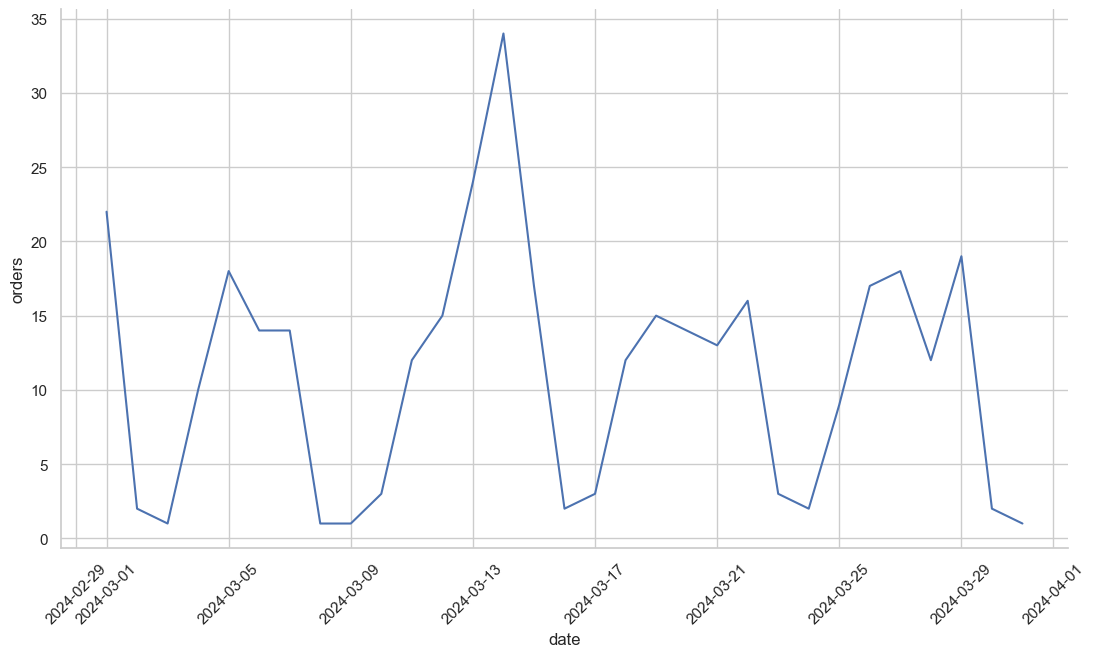

In [13]:
sns.set(style='whitegrid', rc={'figure.figsize':(13,7)})

daily_orders_plot = sns.lineplot(data=daily_orders, x='date', y='orders')
plt.xticks(rotation=45)

plt.minorticks_on()
sns.despine()

## Шаг 5

**Кажется, в данных помимо дня с наибольшим числом заказов есть еще один день, который выбивается из общей картины.** Что это за день:  
- Это воскресенье, в которое было много заказов?  
- Это понедельник, в который было много заказов?  
- Это пятница, в которую было мало заказов?  
- Это праздничный день, в который было мало заказов?

Подумайте, почему так вышло? Укажите этот день в том формате, в котором он представлен в данных (гггг-мм-дд)

In [14]:
# Проверим каждое утверждение в отдельности
daily_orders['day_name'] = daily_orders.date.dt.day_name()

# Это воскресенье, в которое было много заказов?
daily_orders.loc[daily_orders.day_name == 'Sunday']

,date,orders,day_name
2,2024-03-03,1,Sunday
9,2024-03-10,3,Sunday
16,2024-03-17,3,Sunday
23,2024-03-24,2,Sunday
30,2024-03-31,1,Sunday


In [15]:
# Это понедельник, в который было много заказов?
daily_orders.loc[daily_orders.day_name == 'Monday']

,date,orders,day_name
3,2024-03-04,10,Monday
10,2024-03-11,12,Monday
17,2024-03-18,12,Monday
24,2024-03-25,9,Monday


In [16]:
# Это пятница, в которую было мало заказов?
daily_orders.loc[daily_orders.day_name == 'Friday']

,date,orders,day_name
0,2024-03-01,22,Friday
7,2024-03-08,1,Friday
14,2024-03-15,17,Friday
21,2024-03-22,16,Friday
28,2024-03-29,19,Friday


## Шаг 6

К вам пришел радостный руководитель отдела продаж и попросил выяснить причину, почему заказы в один из дней резко подскочили, чтобы и дальше увеличивать продажи.

Возможно, в день с наибольшим числом заказов (который вы определили на третьем шаге) отдел маркетинга запустил какую-то акцию? Или менеджеры стали активнее предлагать компаниям оформить заказ? Нужно подробнее изучить этот день. Начнем со статусов заказа.

In [212]:
orders_status = df_orders.merge(df_order_status, on='order_id')

orders_status.to_csv('orders_status.csv', index=False)

In [213]:
orders_status.head()

,order_id,product_id,quantity,manager,date,client_id,status
0,ABID-18767701,72,30,Маргарита Камертонова,2024-03-11,44,confirmed
1,ABID-18767701,509,40,Маргарита Камертонова,2024-03-11,44,confirmed
2,ABID-18767701,555,26,Маргарита Камертонова,2024-03-11,44,confirmed
3,ABID-18767701,557,30,Маргарита Камертонова,2024-03-11,44,confirmed
4,ABID-18767701,569,28,Маргарита Камертонова,2024-03-11,44,confirmed


Посмотрите на количество и соотношение подтвержденных и отмененных заказов. **В ответе укажите долю отмененных заказов.** Ответ округлите до двух знаков после точки.

In [214]:
confirmed_orders = orders_status.loc[orders_status.status == 'confirmed'].order_id.nunique()

In [215]:
canceled_orders = orders_status.loc[orders_status.status == 'canceled'].order_id.nunique()

In [216]:
part_of_canceled_orders = canceled_orders / (confirmed_orders + canceled_orders)
print(round(part_of_canceled_orders, 2))

0.11


In [217]:
part_of_confirmed_orders = 1 - part_of_canceled_orders

**Посчитайте количество подтвержденных и отмененных заказов на каждую дату.** Определите, в какой день не было ни одного подтвержденного заказа. Для этого сделайте сводную таблицу, где в строках будут даты, в колонках — стутасы заказов, а значения — число заказов с этим статусом в определенную дату. Пропуски заполните нулями.  

1) Данные в датафрейме `orders_status` сгруппируйте по дате и статусу, посчитайте количество уникальных заказов для каждой группы. Получившуюся колонку с числом заказов можете переименовать в `orders`.

In [220]:
orders_status_unique = orders_status.groupby(['date', 'status']).order_id.nunique().reset_index()
orders_status_unique = orders_status_unique.rename(columns={'order_id' : 'orders'})

2) Разверните получившийся датафрейм так, чтобы получилась сводная таблица, где в индексе — даты, в колонках — статусы, а в значениях — количество заказов.  Пропуски заполните нулями.

In [222]:
orders_status_pivot = orders_status_unique.pivot(columns='status', index='date', values='orders').fillna(0)

orders_status_pivot

status,canceled,confirmed
date,,
2024-03-01,2.0,20.0
2024-03-02,0.0,2.0
2024-03-03,0.0,1.0
2024-03-04,0.0,10.0
2024-03-05,0.0,18.0
2024-03-06,1.0,13.0
2024-03-07,1.0,13.0
2024-03-08,0.0,1.0
2024-03-09,1.0,0.0


3) Из-за того, что после разворота таблицы в колонках `canceled` и `confirmed` появились пропущенные значения, тип данных в этих колонках стал `float`. Но число заказов не может быть дробным, поэтому приведите эти колонки к типу `int`.

In [223]:
orders_status_pivot.canceled = orders_status_pivot.canceled.apply(lambda x: int(x))
orders_status_pivot.confirmed = orders_status_pivot.confirmed.apply(lambda x: int(x))

In [224]:
# можно и так
# df['column_name'] = df['column_name'].astype(int)

**В ответ укажите день, когда не было ни одного подтвержденного заказа.** Дату укажите в том формате, в котором она представлена в данных (гггг-мм-дд).

In [225]:
orders_status_pivot.loc[orders_status_pivot.confirmed == 0]

status,canceled,confirmed
date,,
2024-03-09,1,0


## Шаг 9

**Постройте график с заказами по дням в разбивке по статусу заказа.** Посмотрим подробнее на день с наибольшим числом заказов (вместе и подтвержденных, и отменных), который мы определили ранее, и на день, предшествующий ему. Какой вывод можно сделать? Выберите один или несколько вариантов:

- В день с наибольшим числом заказов было очень много отмен  
- В день с наибольшим числом заказов было много успешно оформленных заказов  
- В день, предшествующий дню с наибольшим числом заказов, было много отмен  
- В день, предшествующий дню с наибольшим числом заказов, было много успешно оформленных заказов  
- В день, предшествующий дню с наибольшим числом заказов, не было ни одного успешно оформленного заказа  
- В день, предшествующий дню с наибольшим числом заказов, не было ни одного отмененного заказа

<Axes: xlabel='date'>

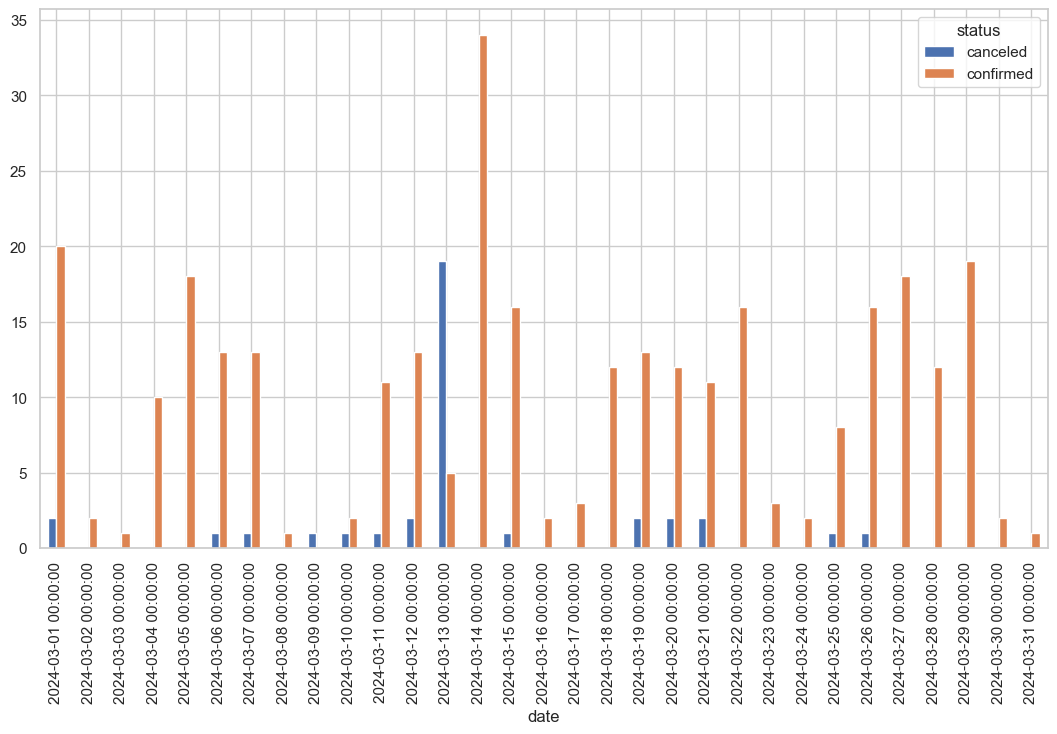

In [233]:
orders_status_pivot.plot(kind='bar')

<Axes: xlabel='date'>

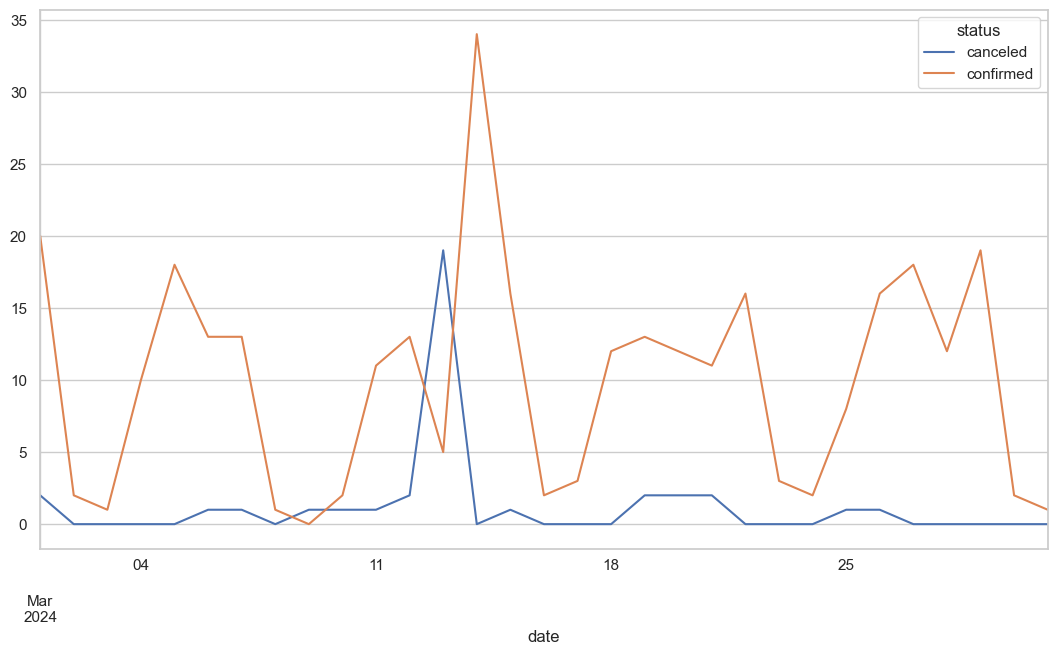

In [234]:
orders_status_pivot.plot(kind='line')

<Axes: xlabel='date', ylabel='orders'>

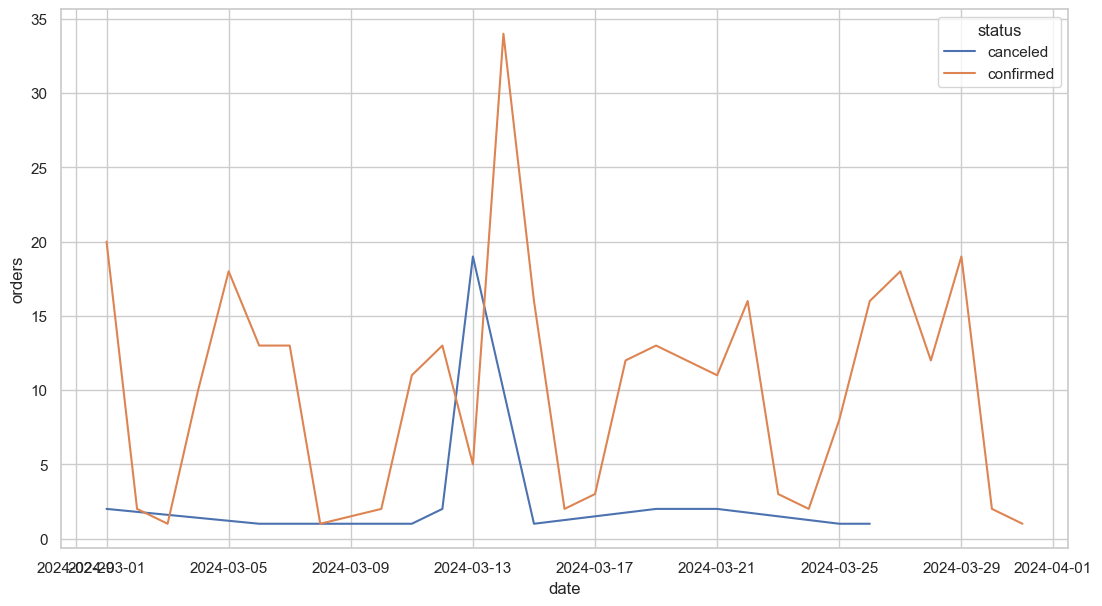

In [230]:

sns.lineplot(data=orders_status_unique, x='date', y='orders', hue='status')


## Шаг 10

Рассмотрим эти два дня отдельно (день с наибольшим числом заказов, который мы определили ранее, и день, предшествующий ему). Проанализируйте заказы за эти дни и ответьте, какую из этих гипотез можно назвать наиболее правдоподобной.

- Так сложилось, что один день оказался крайне неудачным для отдела продаж, все клиенты отменили свои заказы. А на следующий день отдел продаж пытался компенсировать отсутствие продаж в предыдущий и перевыполнил дневной план. Почти все заказы не повторяют вчерашние  
- Произошел сбой в работе CRM системы, который не позволил клиентам подтвердить заказ. В результате все созданные в первый день заказы автоматически отменились, поэтому клиентам пришлось оформлять их повторно на следующий день. Почти половина заказов повторяет вчерашние

Как можно определить, что заказ повторяет вчерашний? У заказов будут совпадать сразу несколько параметров: клиент, менеджер, количество уникальных товаров в заказе и общее число товаров в штуках. Но номера заказов будут разными.

In [245]:
orders_14 = orders_status.loc[(orders_status.date == '2024-03-13')].copy()
orders_13 = orders_status.loc[(orders_status.date == '2024-03-14')].copy()
display(orders_14.head())
display(orders_13.head())

,order_id,product_id,quantity,manager,date,client_id,status
34,AFIH-00611801,17,26,Алексей Саксофонов,2024-03-13,43,canceled
35,AFIH-00611801,240,21,Алексей Саксофонов,2024-03-13,43,canceled
36,AFIH-00611801,468,5,Алексей Саксофонов,2024-03-13,43,canceled
37,AFIH-00611801,505,28,Алексей Саксофонов,2024-03-13,43,canceled
38,AFIH-00611801,511,13,Алексей Саксофонов,2024-03-13,43,canceled


,order_id,product_id,quantity,manager,date,client_id,status
13,ACXS-56511429,250,21,Алексей Саксофонов,2024-03-14,24,confirmed
14,ACXS-56511429,477,16,Алексей Саксофонов,2024-03-14,24,confirmed
15,ACXS-56511429,509,16,Алексей Саксофонов,2024-03-14,24,confirmed
16,ACXS-56511429,534,10,Алексей Саксофонов,2024-03-14,24,confirmed
17,ACXS-56511429,646,18,Алексей Саксофонов,2024-03-14,24,confirmed


In [248]:
same_orders = orders_13.merge(orders_14, on=['client_id', 'manager', 'product_id', 'quantity'])
same_orders.order_id_x.nunique()

16

In [249]:
orders_14.order_id.nunique()

24

In [250]:
orders_13.order_id.nunique()

34

### Посчитаем ключевые метрики, посмотрим на их динамику и составим небольшой отчет

**У вас есть данные за целый месяц, поэтому пора посчитать ключевые метрики этого месяца.** Но вот незадача - в ваших данных цена единицы товара указана в долларах США, потому что закупаете их в долларах, но продаете товары за российские рубли (по тому курсу, который установил Центробанк на дату продажи), а значит и метрики требуется посчитать в рублях. Хорошо, что у вас есть текстовый файл с курсом доллара США на каждую дату. **Откройте файл `usd_rate.txt`, соберите из него датафрейм с 2 колонками: `date` и `currency_rate`. Посчитайте среднее значение курса доллара за месяц.** Результат округлите до двух знаков после точки.

1. Откройте файл usd_rate.txt с помощью контекстного менеджера with и функции open(). Список строк сохраните в переменную currency

In [258]:
with open('usd_rate.txt', 'r', encoding='utf-8') as file:
    currency = file.readlines()

2) С помощью функции `pd.DataFrame(columns=['col_name'])` создайте из списка датафрейм с любым названием единственной колонки.

In [259]:
usd_rate = pd.DataFrame({'currency' : currency}) 
usd_rate

,currency
0,"2024-03-01,90.8423,Доллар США\n"
1,"2024-03-02,91.3336,Доллар США\n"
2,"2024-03-03,91.3336,Доллар США\n"
3,"2024-03-04,91.3336,Доллар США\n"
4,"2024-03-05,91.3534,Доллар США\n"
5,"2024-03-06,91.1604,Доллар США\n"
6,"2024-03-07,90.3412,Доллар США\n"
7,"2024-03-08,90.7493,Доллар США\n"
8,"2024-03-09,90.7493,Доллар США\n"
9,"2024-03-10,90.7493,Доллар США\n"


3) На основе имеющейся колонки создайте колонки `date` и `currency_rate`, куда положите соответствующие данные. Для этого разделите общую строку со всеми данными и возьмите нужные данные по индексу. Переведите колонку `date` в тип `datetime`.

In [285]:
df_usd_rate = (
    usd_rate.currency.str.split(',', expand=True)
    .rename(columns={0 : 'date',
                    1 : 'currency_rate'})
    .drop(2, axis=1)
)

df_usd_rate.date = pd.to_datetime(df_usd_rate.date)
df_usd_rate['currency_rate'] = df_usd_rate['currency_rate'].astype(float)


4) Посчитайте среднее значение курса доллара за месяц. Результат округлите до двух знаков после точки.  

In [290]:
mean_currency = df_usd_rate.currency_rate.mean().round(2)
mean_currency

91.7

## Шаг 12

**Работу с ключевыми метриками начните с подсчета общей выручки.** Данные по товарам в подтвержденных заказах у вас есть в датафрейме `orders_status`, а стоимость одной единицы товара можно взять из датафрейма `df_products`. Объедините эти датафреймы в общий `df_full`, добавьте к ним информацию по курсу доллара на каждую дату. Создайте колонку с выручкой для каждого товара в заказах и посчитайте, **чему равна общая выручка в рублях?** Учитывайте только подтвержденные заказы. Результат округлите до двух знаков после точки.

1. Присоедините к датафрейму orders_status датафрейм df_products, указав, что ключом в левом датафрейме будет являться колонка product_id (параметр left_on), а в правом — колонка id (параметр right_on). Новый датафрейм сохраните в df_full

In [295]:
df_products = df_products.rename(columns={'id' : 'product_id'})

df_orders_with_products = orders_status.merge(df_products, on='product_id')

2) К датафрейму `df_full` добавьте информацию о курсе доллара на каждую дату, присоединив датафрейм `df_currency` по общей колонке с датой.

In [297]:
df_full = df_orders_with_products.merge(df_usd_rate, on='date')
df_full

,order_id,product_id,quantity,manager,date,client_id,status,name,price,category,currency_rate
0,ABID-18767701,72,30,Маргарита Камертонова,2024-03-11,44,confirmed,"Beyerdynamic, DT 990 PRO",158.91,Проводные наушники,90.7493
1,ABID-18767701,509,40,Маргарита Камертонова,2024-03-11,44,confirmed,"Heco, Stay 300",43.95,Проводные наушники,90.7493
2,ABID-18767701,555,26,Маргарита Камертонова,2024-03-11,44,confirmed,"JBL, Charge 4",159.13,Беспроводная акустика,90.7493
3,ABID-18767701,557,30,Маргарита Камертонова,2024-03-11,44,confirmed,"JBL, Xtreme 2",308.70,Беспроводная акустика,90.7493
4,ABID-18767701,569,28,Маргарита Камертонова,2024-03-11,44,confirmed,"JBL, Live 650BTNC",178.47,Беспроводные наушники,90.7493


In [310]:
df_full['revenue'] = df_full.currency_rate * df_full.price * df_full.quantity

,order_id,product_id,quantity,manager,date,client_id,status,name,price,category,currency_rate,revenue_per_product,revenue
0,ABID-18767701,72,30,Маргарита Камертонова,2024-03-11,44,confirmed,"Beyerdynamic, DT 990 PRO",158.91,Проводные наушники,90.7493,432629.14,4.326291e+05
1,ABID-18767701,509,40,Маргарита Камертонова,2024-03-11,44,confirmed,"Heco, Stay 300",43.95,Проводные наушники,90.7493,159537.27,1.595373e+05
2,ABID-18767701,555,26,Маргарита Камертонова,2024-03-11,44,confirmed,"JBL, Charge 4",159.13,Беспроводная акустика,90.7493,375464.34,3.754643e+05
3,ABID-18767701,557,30,Маргарита Камертонова,2024-03-11,44,confirmed,"JBL, Xtreme 2",308.70,Беспроводная акустика,90.7493,840429.27,8.404293e+05
4,ABID-18767701,569,28,Маргарита Камертонова,2024-03-11,44,confirmed,"JBL, Live 650BTNC",178.47,Беспроводные наушники,90.7493,453488.77,4.534888e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4598,ZVTW-19610380,1171,28,Ксения Балалайкина,2024-03-22,44,confirmed,"Pioneer, FAYOLA FS-W40",405.50,Умная колонка,91.9499,1043999.16,1.043999e+06
4599,ZVTW-19610380,1308,4,Ксения Балалайкина,2024-03-22,44,confirmed,"SMSL, SA-36A Pro",59.71,Усилитель мощности,91.9499,21961.31,2.196131e+04
4600,ZVTW-19610380,1476,4,Ксения Балалайкина,2024-03-22,44,confirmed,"TONOR, PA System Karaoke Machine",98.17,Система караоке,91.9499,36106.89,3.610689e+04
4601,ZVTW-19610380,1517,11,Ксения Балалайкина,2024-03-22,44,confirmed,"Wharfedale, OBSIDIAN 600 Cinema",870.99,Домашний кинотеатр,91.9499,880961.88,8.809619e+05


5) Отберите только записи с подтвержденными заказами и сохраните результат в датафрейм `df_confirmed`, он вам ещё пригодится.

In [311]:
df_confirmed = df_full.loc[df_full.status == 'confirmed']

In [314]:
full_revenur = df_confirmed.revenue.sum().round(2)
full_revenur

## Шаг 13

**Следующая метрика, которую вам нужно посчитать — средний чек в этом месяце (в рублях).** Разделите общую выручку на количество заказов. Результат округлите до двух знаков после точки.

In [317]:
amount_of_orders = df_confirmed.order_id.nunique()
average_bill = round(full_revenur / amount_of_orders, 2)
average_bill

6596219.49

## Шаг 14

Ключевые метрики месяца вы посчитали, теперь попробуйте посмотреть на их динамику внутри месяца: посчитайте выручку, средний чек и число заказов — на каждый день. Посмотрите на графики и выберите верные ответы:

- число заказов и выручка каждый день изменяются в одинаковом направлении (если в этот день число заказов выросло, то и выручка выросла; число заказов упало — в этот же день упала и выручка)  
- число заказов и выручка не каждый день изменяются в одинаковом направлении (если в какой-то день число заказов выросло, то выручка может упасть, и наоборот: число заказов упало — в этот же день выручка выросла)  
- средний чек и выручка каждый день изменяются в одинаковом направлении (если в этот день средний чек вырос, то и выручка выросла; средний чек упал — в этот же день упала и выручка)  
- средний чек и выручка не каждый день изменяются в одинаковом направлении (если в какой-то день средний чек вырос, то выручка может упасть, и наоборот: средний чек упал — в этот же день выручка выросла)  
- в день с наибольшим числом заказов и выручка, и средний чек также показывают максимальное значение  
- в день с наибольшим числом заказов выручка и/или средний чек не показывают максимальное значение  
- с течением времени выручка то увеличивается, то уменьшается  
- с течением времени выручка только увеличивается  
- на протяжении всего месяца средний чек то увеличивается, то уменьшается  
- средний чек на протяжении всего месяца имеет одинаковое значение

In [342]:
# выручка за день revenue.sum
# средний чек revenue.sum / order_id.unique

confirmed_per_day = df_confirmed[['date', 'revenue_per_product', 'order_id']].\
    groupby(['date'], as_index=False).\
    agg({'revenue_per_product' : 'sum',
        'order_id' : 'nunique'}).\
    rename(columns= {'order_id' : 'orders'}).\
    assign(average_bill= lambda x: x['revenue_per_product'] / x['orders'])

confirmed_per_day[['revenue_per_product', 'average_bill']] = confirmed_per_day[['revenue_per_product', 'average_bill']].round(2)


155411755.93

In [429]:
print('правильные ответы: ' + "2, 4, 6, 7, 9")

правильные ответы: 2, 4, 6, 7, 9


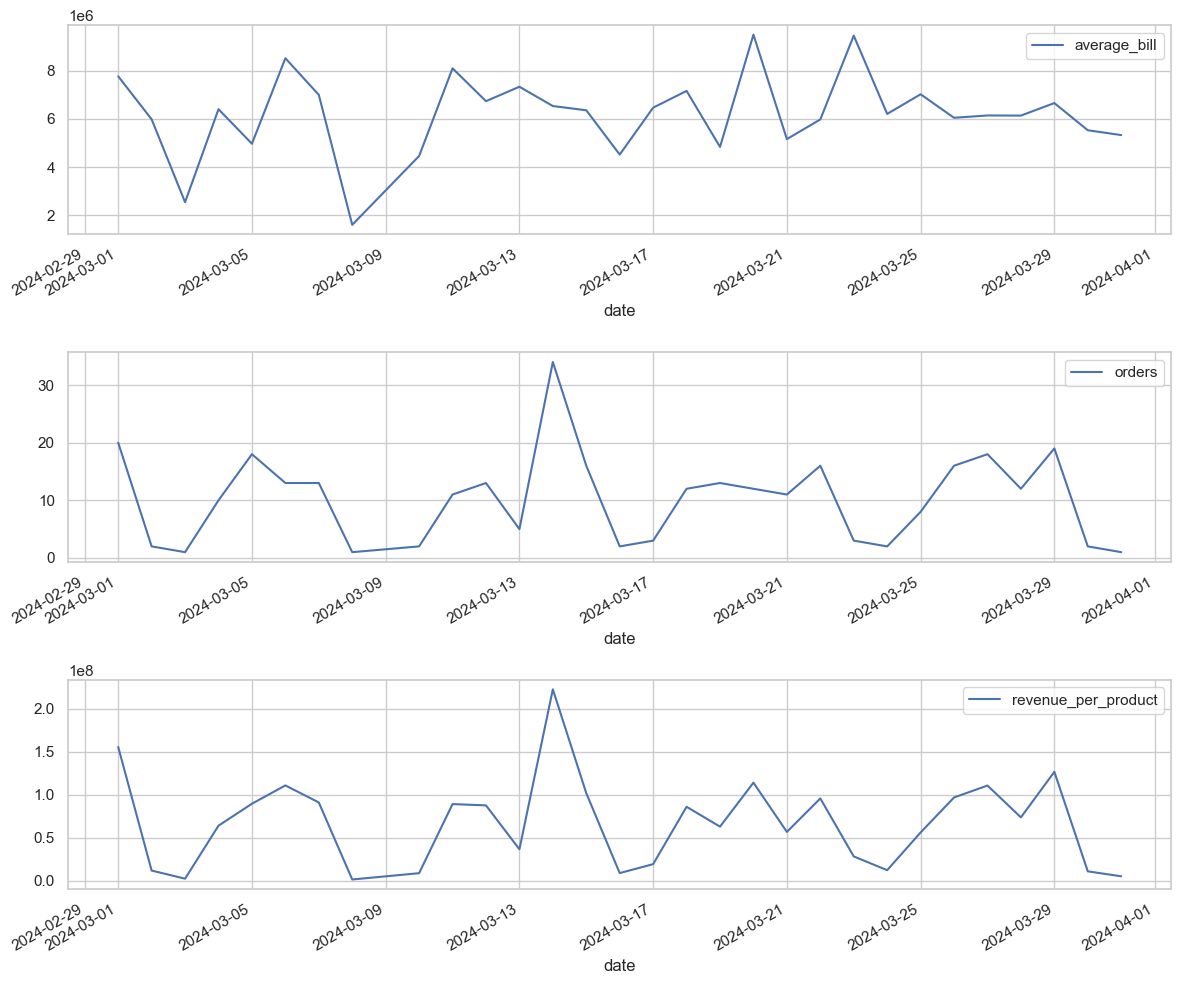

In [427]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

confirmed_per_day.plot('date', 'average_bill', ax=axes[0])
confirmed_per_day.plot('date', 'orders', ax=axes[1])
confirmed_per_day.plot('date', 'revenue_per_product', ax=axes[2])
plt.tight_layout()

### Проанализируем интерес клиентов к брендам

## Шаг 15

К вам снова обратился руководитель отдела продаж. Он хочет разобраться, какие бренды востребованы среди клиентов, а какие — нет. На основе данных о названиях товаров в датафрейме `df_full` создайте новую колонку `brand`, где будет только название бренда. **Посчитайте, сколькими брендами интересовались клиенты** (статус заказа здесь не важен, если запись о бренде попала в данные о заказах, значит клиент заказал или хотел заказать товар этого бренда).

In [358]:
df_full['brand'] = df_full.name.apply(lambda x: x.split(',')[0])

df_full.brand.nunique()

121

## Шаг 16

Посчитайте, какую выручку принес каждый бренд и в скольких подтвержденных заказах были товары этого бренда. **Определите, какой бренд принес наибольшую выручку.** В ответ укажите его название.

Дополнительно: проверьте, именно этот бренд встречается в большем количестве заказов, чем другие бренды? Или может его реже заказывают, но на более крупные суммы?


      
1) Отберите в датафрейме `df_full` только подтвержденные заказы.

2) Сгруппируйте данные по брендам и посчитайте выручку и количество уникальных заказов.

3) Отсортируйте агрегированные данные по убыванию выручки и посмотрите бренд в верхней строчке.

In [366]:
df_full.loc[df_full.status == 'confirmed'].\
    groupby('brand', as_index=False).\
    revenue.sum().sort_values(by='revenue')

,brand,revenue
24,Creative,1.001419e+04
18,Bravo Audio,2.405086e+04
1,ART,2.670040e+04
40,Fosi Audio,3.129419e+04
8,AudioSource,3.388167e+04
...,...,...
49,KEF,1.465101e+08
120,Yamaha,1.658651e+08
53,Klipsch,2.039024e+08
43,Heco,2.388163e+08


4) Дополнительно: отсортируйте агрегированные данные по убыванию количество заказов и посмотрите бренд в верхней строчке.

## Шаг 17

У одних брендов большинство товаров востребовано клиентами, а у других — клиенты заказывают только небольшую часть товаров, а остальные зря занимают виртуальную «полку» в перечне товаров, продаваемых вашей компанией. **Вам нужно определить, какие бренды редко попадают в заказы, хотя товаров таких брендов на самом деле много.**

Начнем с того, что определим, какие товары из имеющихся в продаже хоть раз заказывали, а какие — нет. Для этого соберите список из перечня уникальных идентификаторов товаров, которые встречаются в датафрейме `df_confirmed`. После этого для каждого товара в датафрейме `df_products` определите, был ли этот товар в списке заказанных товаров в этом месяце или нет: создайте новую колонку `is_in_orders` и заполните её соответственно значениями `yes` или `no` для каждого товара.

**В ответе укажите, сколько товаров были заказаны, а сколько — не были**

<details>
<summary>&#9658; Нажмите сюда, чтобы увидеть подсказку</summary>
  <p>
      
1) Сохраните в список `products_in_orders` уникальные идентификаторы товаров из датафрейма `df_confirmed`.
      
2) Создайте в датафрейме `df_products` новую колонку `is_in_orders`, в которой будет значение `yes`, если значение из колонки `id` этого датафрейма есть в списке `products_in_orders`. Если его в этом списке нет - в новую колонку для этой строчки запишите значение `no`.
      
3) Посчитайте количество встречающихся значений `yes` и  `no` в колонке `is_in_orders`.
      
</p>
</details>

In [369]:
unique_products = df_confirmed.product_id.unique()

df_products['is_in_orders'] = df_products['product_id'].apply(lambda x: 'yes' if x in unique_products else 'no')

In [371]:
df_products.is_in_orders.value_counts()

is_in_orders
yes    1180
no      497
Name: count, dtype: int64

## Шаг 18

Примерно треть товаров не была заказана ни разу в этом месяце. Посмотрим на эти данные в разрезе по брендам. **Определите, у каких брендов доля ни разу не заказанных товаров была больше половины от всех продаваемых товаров этого бренда.** Но не берите в расчет бренды, которые представлены маленьким числом товаров (меньше 15), они не захламляют виртуальную «полку».

Отметьте бренды, у которых доля ни разу не заказанных товаров была больше половины от всех продаваемых товаров этого бренда: 
- AKG  
- ASUS	
- Dali  
- Emotiva  
- KEF  
- Marantz  
- Onkyo  
- Pioneer  
- Yaqin

<details>
<summary>&#9658; Нажмите сюда, чтобы увидеть подсказку</summary>
  <p>
       
1) В датафрейме `df_products` создайте новую колонку `brand`, в которую поместите только названия брендов. Для этого разделите значения в колонке `name` и возьмите первое из них (сначала идет бренд и через запятую модель товара).
      
2) Сгруппируйте данные по бренду и колонке, в которой указано, есть товар в заказах, и посчитайте число уникальных товаров. Колонку с числом товаров можете переименовать в `products`.
      
3) Разверните сгруппированные данные так, чтобы получилась сводная таблица в которой в индексе названия брендов, в колонках - есть товар в заказах или нет (`yes` и `no`), в значениях - количество товаров.
      
4) Заполните пропуски нулями.
      
5) Сбросьте индекс, чтобы названия брендов стали колонкой.
      
6) Посчитайте общее число товаров для каждого бренда, сложив значения в колонках `yes` и `no`.
      
7) Для каждого бренда посчитайте долю ни разу не заказанных товаров от всех продаваемых товаров этого бренда.
      
8) Отберите только те бренды, где общее число товаров больше 15 и доля ни разу не заказанных товаров больше половины (0.5).
      
</p>
</details>

In [392]:
# Ваш код здесь
df_products['brand'] = df_products.name.apply(lambda x: x.split(',')[0])
is_in_orders = df_products.groupby(['brand', 'is_in_orders'], as_index=False).product_id.count().\
    rename(columns={'product_id' : 'products'})

is_in_orders['total_by_brand'] = is_in_orders.groupby('brand').products.transform('sum')

is_in_orders['is_in_part'] = is_in_orders['products'] / is_in_orders['total_by_brand']

is_in_orders.loc[(is_in_orders.total_by_brand > 15) & (is_in_orders.is_in_orders == 'no')].query('is_in_part > 0.5')

,brand,is_in_orders,products,total_by_brand,is_in_part
44,Dali,no,49,67,0.731343
88,KEF,no,54,82,0.658537
115,Marantz,no,19,22,0.863636
141,Pioneer,no,70,103,0.679612


### Составим отчет по продажам менеджеров

## Шаг 19

Чтобы компания знала, кого из менеджеров отдела продаж премировать, а с кем провести беседу по итогам месяца, **вас попросили сделать отчет по сделкам каждого менеджера**: сколько он оформил подтвержденных заказов и какую выручку они принесли. Но в абсолютных числах вклад каждого сотрудника может быть непонятен. **Поэтому посчитайте значения в процентах: какой % выручки от общей выручки за месяц приходится на каждого менеджера, и какой % заказов от общего числа заказов.** Посчитайте данные и визуализируйте результат, чтобы принимать решение о поощрении или проведении беседы с менеджерами было удобнее. Выберите верные ответы:

- лучшим менеджером по % выручки стала Маргарита Камертонова  
- лучшим менеджером по % заказов стала Маргарита Камертонова  
- первая пятерка менеджеров по % выручки сильно ушла вперед от всех остальных (явно виден большой разрыв между каждым из первой пятерки и каждым из всех остальных менеджеров)  
- в этом месяце нельзя выделить явную пятерку лидеров по % выручки, которые сильно оторвались от остальных  
- лидер по % заказов реализовал более 16% заказов  
- лидер по % заказов реализовал менее 16% заказов  
- наихудшие показатели у Сергея Контрабасова  
- наихудшие показатели у Аркадия Октавина  
- Антон Скрипкин принес в 3 раза меньше выручки, чем Виктор Тромбонов  
- Антон Скрипкин реализовал почти в 3 раза меньше заказов, чем Анастасия Дудкина

<details>
<summary>&#9658; Нажмите сюда, чтобы увидеть подсказку</summary>
  <p>
       
1) Сгруппируйте данные с подтвержденными заказами из датафрейма `df_confirmed` по менеджерам и посчитайте для каждого сумму выручки и количество заказов. Получившуюся колонку с числом заказов можете переименовать в `orders`.
      
2) Отсортируйте записи по убыванию выручки.
      
3) Посчитайте процент выручки, приходящейся на каждого менеджера: разделите его выручку на суммарную выручку всех менеджеров и умножьте результат на 100. Округлите до двух знаков после точки.
      
4) Посчитайте процент заказов, приходящихся на каждого менеджера: разделите его число заказов на суммарное число заказов всех менеджеров и умножьте результат на 100. Округлите до двух знаков после точки.   
      
5) Постройте два барплота (столбиковые диаграммы): со значениями % выручки и % заказов у каждого менеджера.
      
</p>
</details>

In [410]:
confirmed_by_manager = df_full.loc[df_full.status == 'confirmed'].groupby('manager', as_index=False).\
    agg({'order_id' : 'nunique', 'revenue_per_product' : 'sum'}).\
    rename(columns={'order_id' : 'orders', 'revenue_per_product' : 'revenue'}).\
    sort_values(by='orders')

confirmed_by_manager['percentage_revenue'] = round(confirmed_by_manager['revenue'] / confirmed_by_manager['revenue'].\
    sum() * 100, 2)

confirmed_by_manager['percentage_orders'] = round(confirmed_by_manager['orders'] / confirmed_by_manager['orders'].\
    sum() * 100, 2)

confirmed_by_manager

,manager,orders,revenue,percentage_revenue,percentage_orders
3,Аркадий Октавин,5,2.973678e+07,1.46,1.62
11,Сергей Контрабасов,5,2.857223e+07,1.40,1.62
2,Антон Скрипкин,7,5.150268e+07,2.53,2.27
1,Анастасия Дудкина,20,1.234504e+08,6.06,6.47
10,Надежда Гармошкина,21,1.347836e+08,6.61,6.80
0,Алексей Саксофонов,27,1.953435e+08,9.58,8.74
7,Ксения Балалайкина,27,1.817621e+08,8.92,8.74
6,Екатерина Тарелкина,28,1.781576e+08,8.74,9.06
5,Владимир Ударников,31,2.084865e+08,10.23,10.03
8,Максим Барабанов,40,2.401478e+08,11.78,12.94


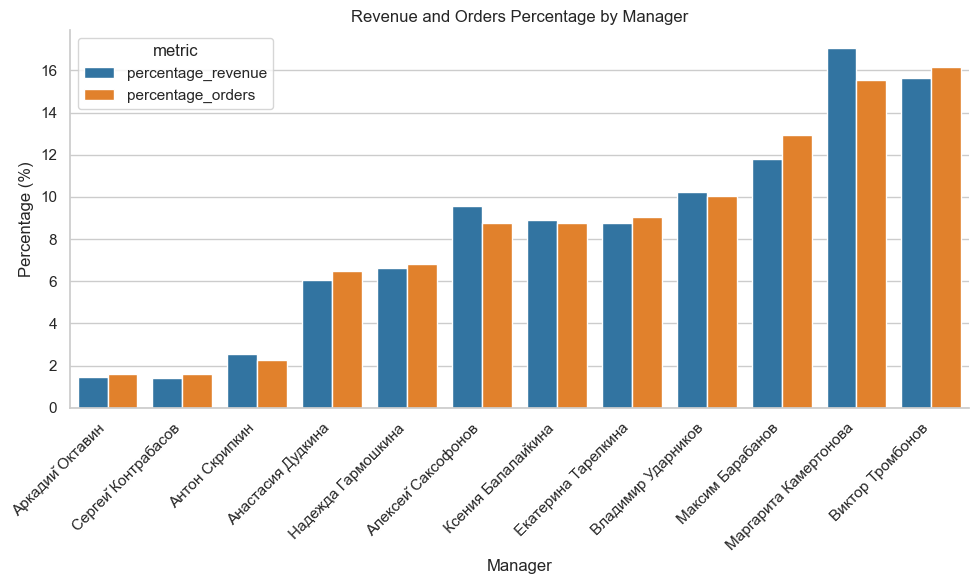

In [421]:
# Преобразуем данные в нужный формат
melted_data = pd.melt(
    confirmed_by_manager,
    id_vars=['manager'],
    value_vars=['percentage_revenue', 'percentage_orders'],
    var_name='metric',
    value_name='value'
)

# Строим барплот с рядом стоящими столбцами
plt.figure(figsize=(10, 6))
sns.barplot(
    data=melted_data,
    x='manager',
    y='value',
    hue='metric',
    palette=['#1f77b4', '#ff7f0e']  # синий и оранжевый
)

plt.xticks(rotation=45, ha='right')
plt.title('Revenue and Orders Percentage by Manager')
plt.ylabel('Percentage (%)')
plt.xlabel('Manager')

sns.despine()
plt.tight_layout()
plt.show()